# Task

Predict the rating a user will give a product.

# Importing Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm

/Users/jpuray/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jpuray/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/jpuray/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Importing Data
products = pd.read_csv("data/product_info.csv")
reviews = pd.read_csv("data/reviews_0-250.csv",index_col=0) # only using first 100_000 rows of reviews

/var/folders/_n/2lzdwcvx2n9087rmk11qlfdw0000gn/T/ipykernel_57968/2225516502.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv("data/reviews_0-250.csv",index_col=0) # only using first 100_000 rows of reviews


In [3]:
print(products.shape)
print(reviews.shape)

(8494, 27)
(602130, 18)


In [4]:
reviews.columns

Index(['author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'],
      dtype='object')

# Exploratory Data Analysis

In [5]:
# Querying for necessary columns
products = products[['product_id','brand_id','loves_count','rating','reviews','price_usd','primary_category']]
reviews = reviews[['author_id','product_id','rating','is_recommended','helpfulness','submission_time','review_text','review_title']]

In [6]:
# Percentages of null data 

In [7]:
reviews.isnull().sum() / reviews.shape[0]

author_id          0.000000
product_id         0.000000
rating             0.000000
is_recommended     0.195117
helpfulness        0.551097
submission_time    0.000000
review_text        0.001659
review_title       0.277367
dtype: float64

In [8]:
products.isnull().sum() / products.shape[0]

product_id          0.000000
brand_id            0.000000
loves_count         0.000000
rating              0.032729
reviews             0.032729
price_usd           0.000000
primary_category    0.000000
dtype: float64

In [9]:
# Distributions of key features

In [10]:
products['rating'].value_counts() 

rating
5.0000    256
4.0000    174
4.5000     82
4.3333     68
3.0000     66
         ... 
4.6954      1
4.2841      1
4.3613      1
4.6878      1
4.6367      1
Name: count, Length: 4394, dtype: int64

Text(0.5, 1.0, 'Histogram of Ratings')

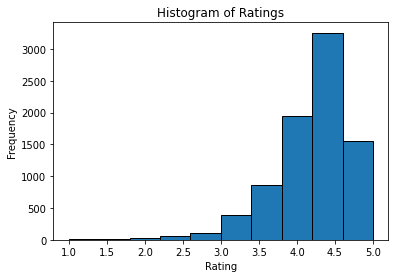

In [11]:
# Plotting the histogram
plt.hist(products['rating'], edgecolor='black')

# Adding labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')

Ratings are skewed to being more positive

# Baseline Models

A simple model we can implement is to predict that a user will give a product its already average rating.

In [12]:
itemAvg = products.set_index('product_id')['rating'].to_dict()
globalAvg = products['rating'].mean()

In [13]:
def avgRating(product_id):
    if product_id not in itemAvg: # return globalAvg if product has not been seen before
        return [globalAvg]
    return [itemAvg[product_id]]

In [14]:
# Predicting ratings
y = np.array(reviews.rating)
y_pred = reviews.product_id.apply(avgRating).to_list()

In [15]:
# Model Evaluation
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f'MSE:{mse}')
print(f'RMSE:{rmse}') 

MSE:1.258782907660306
RMSE:1.121954949033296


This model's predictions are off by about 1.12. Since rating go from a scale from 1 - 5 this model performs pretty bad being off by 1.12 is pretty bad.

Another model we can exlore is to determine the deviations each user has in their personal ratings and the deviations each item has compared to the global averages. 

In [16]:
# Create training and test set for reviews 
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(reviews, test_size=0.2, random_state=42)

In [17]:
# Splitting data and maintaining distribution of ratings in training and test set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in split.split(reviews, reviews["rating"]):
        strat_train_set = reviews.loc[train_index]
        strat_test_set = reviews.loc[test_index]

In [18]:
reviews.rating.value_counts() / len(reviews)

rating
5    0.646040
4    0.177629
3    0.073104
1    0.054644
2    0.048583
Name: count, dtype: float64

In [19]:
strat_train_set.rating.value_counts() / len(strat_train_set)

rating
5    0.646040
4    0.177630
3    0.073103
1    0.054646
2    0.048582
Name: count, dtype: float64

In [20]:
# Creating Model

In [21]:
# Functions for the model 

# Create feature vector
def features(datum, alpha, betaU, betaI):
    user = datum.author_id
    item = datum.product_id
    
    # logic for users or items not seen in the training set
    if user in betaU:
        bu = betaU[user]
    else:
        bu = 0
        
    if item in betaI:
        bi = betaI[item]
    else:
        bi = 0
        
    return [alpha, bu, bi]

def predict_rating(datum):
    a = datum[0]
    bu = datum[1]
    bi = datum[2]
    return a + bu + bi

In [22]:
ratingsPerUser = strat_train_set.groupby('author_id')['rating'].count().to_dict()
ratingsPerItem = strat_train_set.groupby('product_id')['rating'].count().to_dict()

userAvg = strat_train_set.groupby('author_id')['rating'].mean().to_dict()
itemAvg = products.set_index('product_id')['rating'].to_dict()
#itemAvg = strat_train_set.groupby('product_id')['rating'].mean().to_dict()

In [23]:
MSEs = defaultdict(list)

In [24]:
# Initializing values 

alpha = globalAvg
betaU = {}
betaI = {}

for u in userAvg:
    betaU[u] = userAvg[u] - alpha
for i in itemAvg:
    betaI[i] = itemAvg[i] - alpha

# Opitmization (Gradient Descent) 

lam = 0 # can change to increase/descrease error  

prev_mse = 0
iteration = 1

# Training sets
y = np.array(strat_train_set.rating)

for i in range(1):
    alphas = []
    betaUs = defaultdict(list)
    betaIs = defaultdict(list)
    
    for index, row in tqdm(strat_train_set.iterrows()):
        user = row.author_id
        item = row.product_id
        rating = row.rating
        bu = betaU[user]
        bi = betaI[item]

        alphas.append(rating - (bu + bi))
        betaUs[user].append(rating - (alpha + bi))
        betaIs[item].append(rating - (alpha + bu))
    
    alpha = sum(alphas) / len(strat_train_set)
    
    for u in betaUs:
        betaU[u] = sum(betaUs[u]) / (lam + ratingsPerUser[u])

    for i in betaIs:
        betaI[i] = sum(betaIs[i]) / (lam + ratingsPerItem[i])

    # Caclculate MSE 
    X = [features(row, alpha, betaU, betaI) for index,row in strat_train_set.iterrows()]
    y_pred = [predict_rating(x) for x in X]
    trainMse = mean_squared_error(y, y_pred)
    
    print(f"Iteration {iteration}, MSE: {trainMse}, MSE Difference: {abs(prev_mse-trainMse)}")
    if abs(trainMse - prev_mse) < 0.1 or (prev_mse < trainMse and prev_mse != 0): break
    
#    MSEs[lam].append((trainMse, iteration))
    iteration += 1
    prev_mse = trainMse

481704it [00:19, 25056.40it/s]


Iteration 1, MSE: 0.2869475500189116, MSE Difference: 0.2869475500189116


In [25]:
# Keeping track of beset lambdas 
MSEs = {0:(1,0.2869475500189116), 0.5:(1,0.37123573326746806),0.7:(1,0.417800212704393),
        1.1:(1,0.5051117828232283), 1.2:(1,0.5250825093376316), 1.3:(1,0.5442690897035047),
        1.5:(1,0.5803521882037794), 1.7:(1,0.6135531708458034)}

In [26]:
# Model Evaluation

In [27]:
X_test = [features(row, alpha, betaU, betaI) for index,row in strat_test_set.iterrows()]
y_pred = [predict_rating(x) for x in X_test]
y = np.array(strat_test_set.rating)

testMse = mean_squared_error(y, y_pred)
testRmse = np.sqrt(testMse)
print(f'Test MSE: {testMse}')
print(f'Test RMSE: {testRmse}')

Test MSE: 1.2062849300869145
Test RMSE: 1.0983100336821632
